# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import torch
import spacy

import matplotlib.pyplot as plt
import missingno as msno

import transformers
from transformers import AutoTokenizer, AutoModel


from tqdm import tqdm
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
df =  pd.read_csv("C:\\Users\\Korisnik\\Downloads\\toxic_comments.csv",index_col=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


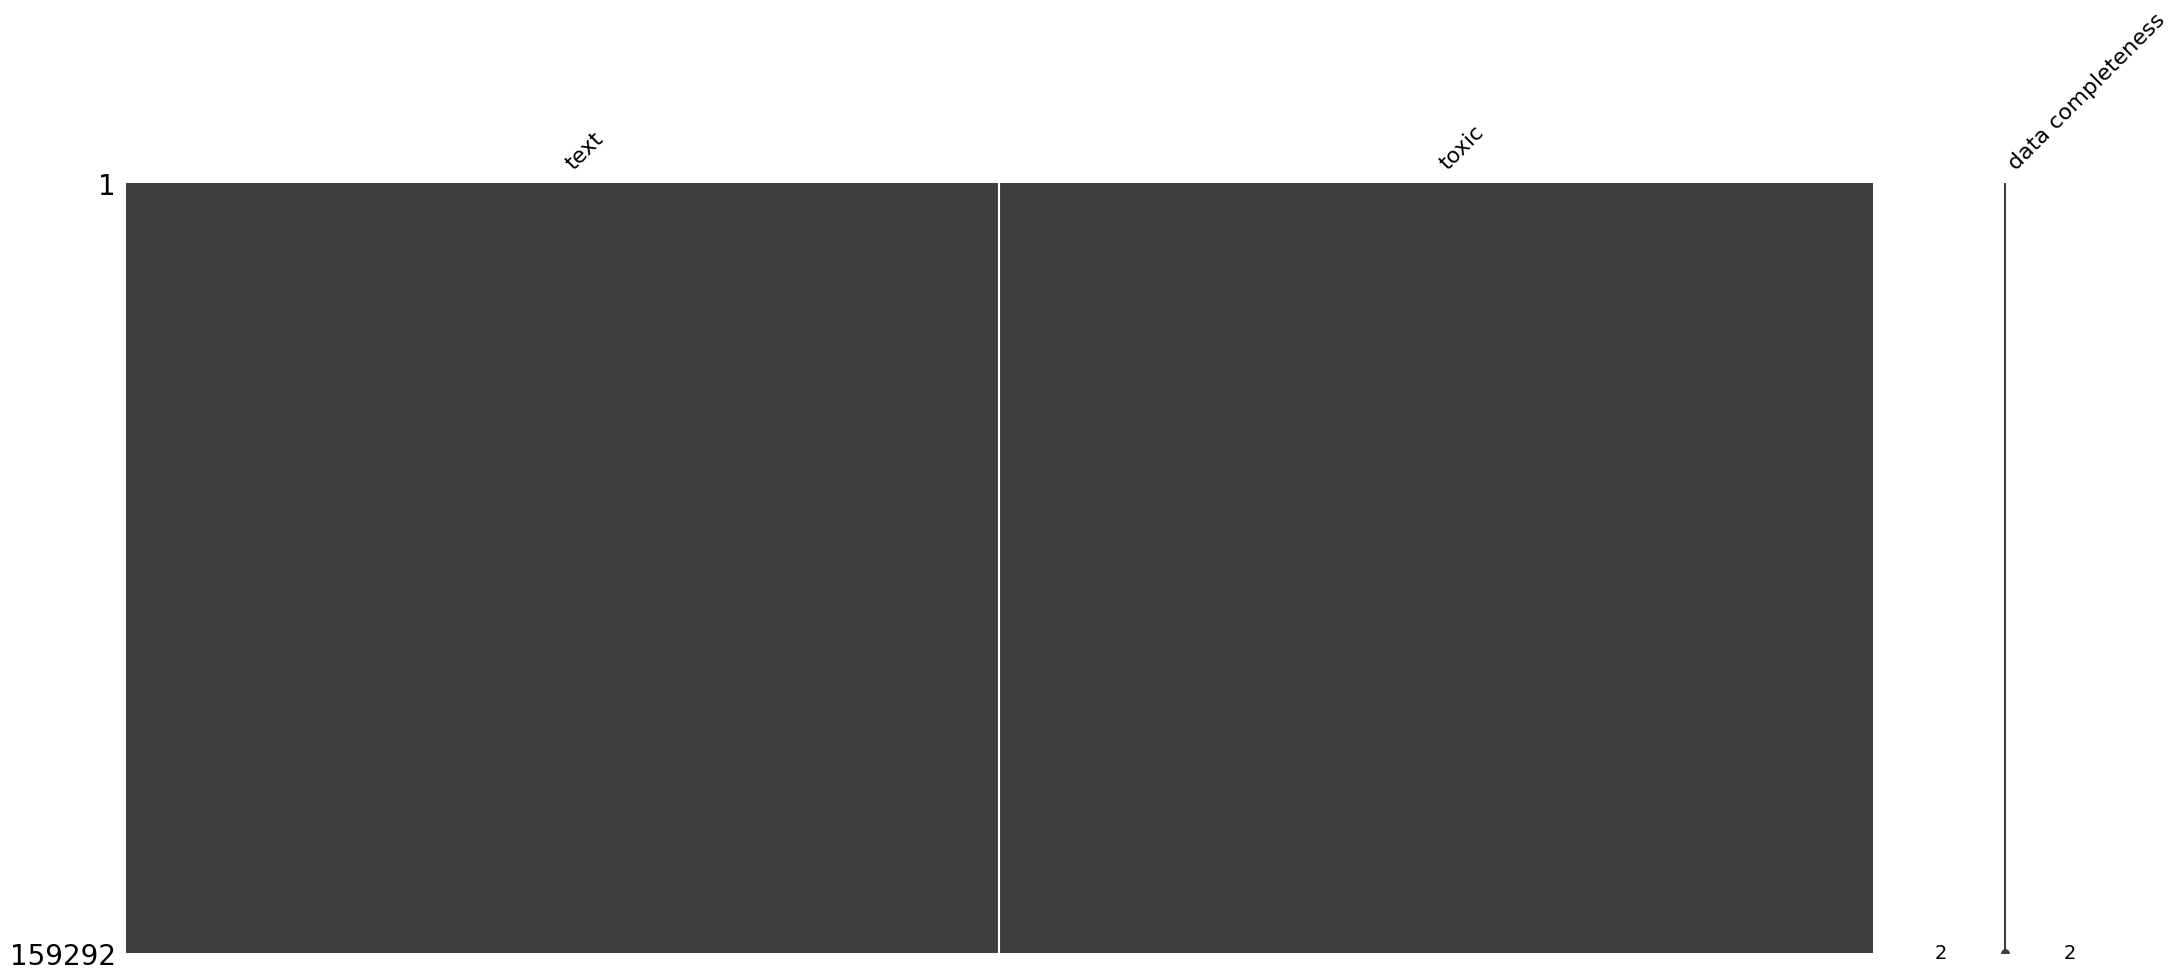

In [5]:
msno.matrix(df, labels=True)
plt.show()

In [6]:
df.duplicated().sum()

0

В данных нет ни дубликатов, ни пропусков. Можно приступать к обучению.

## Обучение

### BERT

In [7]:
print(torch.cuda.is_available())

True


Проверил наличие кудо, так как он понадобится для работы с BERT.

In [8]:
texts = df['text'].tolist()

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

batch_size = 2
embeddings = []

for i in tqdm(range((input_ids.shape[0] + batch_size - 1) // batch_size), desc="Processing Batches"):
    batch = input_ids[batch_size*i:batch_size*(i+1)].to(device)
    attention_mask_batch = attention_mask[batch_size*i:batch_size*(i+1)].to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())
    del batch
    del attention_mask_batch
    del batch_embeddings

features = np.concatenate(embeddings)

Processing Batches:   0%|                                                                    | 0/79646 [00:00<?, ?it/s]C:\Users\Korisnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Processing Batches: 100%|██████████████████████████████████████████████████████| 79646/79646 [2:35:21<00:00,  8.54it/s]


In [9]:
label = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

lr_model = LogisticRegression(random_state=42, max_iter=100000)

lr_param_grid = {
    'C': [0.001, 1, 10]
}

grid_search_lr_bert = GridSearchCV(lr_model,
                                   lr_param_grid,
                                   cv=3,
                                   scoring='f1',
                                   verbose=2,
                                   n_jobs=-1)

grid_search_lr_bert.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=100000, random_state=42),
             n_jobs=-1, param_grid={'C': [0.001, 1, 10]}, scoring='f1',
             verbose=2)

In [10]:
y_pred = grid_search_lr_bert.predict(X_test)

f1 = grid_search_lr_bert.best_score_
print(f'F1 Score: {f1}')

F1 Score: 0.7256003004965331


### Обучение без BERT

In [11]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

tqdm.pandas(desc="Lemmatizing")
df['lemmatized_text'] = df['text'].progress_apply(lemmatize_text)

Lemmatizing: 100%|█████████████████████████████████████████████████████████████| 159292/159292 [32:16<00:00, 82.27it/s]


In [12]:
df.head()

,text,toxic,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation \n edit username Hardcore Metallic...
1,D'aww! He matches this background colour I'm s...,0,D'aww match background colour seemingly stick ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,\n \n real suggestion improvement wonder secti...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_text'], df['toxic'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
vectorized = vectorizer.fit(X_train,y_train)
X_train_vectorized = vectorized.transform(X_train)
X_test_vectorized = vectorized.transform(X_test)

In [14]:
lr_model = LogisticRegression(random_state=42, max_iter=100000)

lr_param_grid = {
    'C': [0.001, 1, 10]
}

grid_search_lr = GridSearchCV(lr_model,
                                   lr_param_grid,
                                   cv=3,
                                   scoring='f1',
                                   verbose=2,
                                   n_jobs=-1)

grid_search_lr.fit(X_train_vectorized, y_train)



f1 = grid_search_lr.best_score_
print(f'F1 Score: {f1}')

Fitting 3 folds for each of 3 candidates, totalling 9 fits
F1 Score: 0.7639445256068468


In [15]:
knn_model = KNeighborsClassifier()

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(knn_model,
                               knn_param_grid,
                               cv=3,
                               scoring='f1',
                               verbose=2,
                               n_jobs=-1)

grid_search_knn.fit(X_train_vectorized, y_train)

y_pred = grid_search_knn.predict(X_test_vectorized)

f1 = grid_search_knn.best_score_
print(f'F1 Score: {f1}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\Korisnik\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan 0.37223054]
  warnings.warn(


F1 Score: 0.37223054087567226


Логистическая модель без BERT показала себя лучше, проверим ее на тестовых данных.

In [16]:
y_pred = grid_search_lr.predict(X_test_vectorized)
f1_lr = f1_score(y_test,y_pred)
print('Метрика лучшей модели',f1_lr)

Метрика лучшей модели 0.7653910149750416


## Выводы

<h1>Проект по Классификации Твитов</h1>
    <p>В ходе проекта по классификации твитов на положительные и отрицательные, я провел следующие шаги:</p>
    <p>C помощью BERT подготовил данные и обучил линейную модель.</p>
    <p>Далее я обучил 2 модели не используя BERT.Подключив библиотеку <span class="highlight">Spacy</span>, я лемматизировал текст твитов, чтобы нормализовать слова и уменьшить их до базовой формы.</p>
    <p>Затем я преобразовал лемматизированный текст в числовой формат с помощью <span class="highlight">CountVectorizer</span> для последующего обучения модели.</p>
    <p>Я обучил логистическую регрессию и она показала результат с F1-метрикой 0.76, так же мню была обучена модель KNN и она показал результат 0.45</p>
    <p>Я рекомендую внедрить логистическую модель в их сервис, тк она подходит под условия заказчика.</p>